# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察填補缺值以及 標準化 / 最小最大化 對數值的影響

# [作業重點]
- 觀察替換不同補缺方式, 對於特徵的影響 (In[4]~In[6], Out[4]~Out[6])
- 觀察替換不同特徵縮放方式, 對於特徵的影響 (In[7]~In[8], Out[7]~Out[8])

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mode
import copy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

data_path = './data/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

In [2]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [4]:
train_Y = df_train['Survived']
#ids = df_test['PassengerId']
train_X = df_train.drop(['PassengerId', 'Survived'] , axis=1)
#df_test = df_test.drop(['PassengerId'] , axis=1)
#df = pd.concat([df_train,df_test])
train_X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(train_X.dtypes, train_X.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



In [6]:
# 削減文字型欄位, 只剩數值型欄位
train_X = train_X[num_features]
train_num = train_Y.shape[0]
print(f'train_num is: {train_num}')
print('\n')
print(train_X.head())

train_num is: 891


   Pclass   Age  SibSp  Parch     Fare
0       3  22.0      1      0   7.2500
1       1  38.0      1      0  71.2833
2       3  26.0      0      0   7.9250
3       1  35.0      1      0  53.1000
4       3  35.0      0      0   8.0500


# 作業1
* 試著在補空值區塊, 替換並執行兩種以上填補的缺值, 看看何者比較好?

In [7]:
#Create function for ECDF
def ecdf(data):
    xaxis= np.sort(data) #sort the data
    yaxis= np.arange(1,len(data)+1)/len(data)   #create percentages for y axis from 1% to 100%
    return xaxis, yaxis

In [8]:
train_X.SibSp.value_counts().sort_values(ascending=False)

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

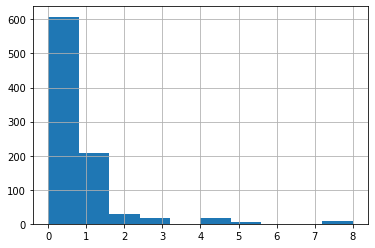

In [9]:
# hist of SibSp
train_X.SibSp.hist()

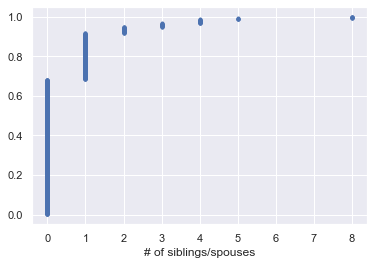

In [10]:
# draw ECDF
sns.set()
x, y = ecdf(train_X['SibSp'])
plt.xlabel('# of siblings/spouses')
plt.plot(x,y, marker='.', linestyle='none')

In [11]:
# deal with Sibsp first
train_X['SibSp'] = train_X['SibSp'].clip(upper=5) # view those >= 5 as 5.

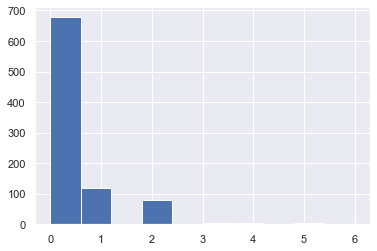

In [12]:
# deal with Parch, hist
train_X.Parch.hist()

In [13]:
train_X.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

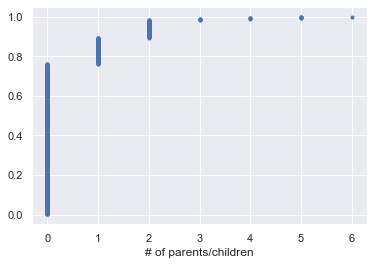

In [14]:
# deal with Parch, ECDF
sns.set()
x, y = ecdf(train_X['Parch'])
plt.xlabel('# of parents/children')
plt.plot(x,y, marker='.', linestyle='none')

In [15]:
# deal with Parch
train_X['Parch'] = train_X['Parch'].clip(upper=4) # view those >= 4 as 4.

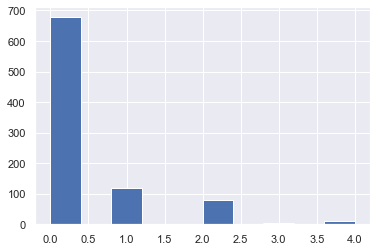

In [16]:
# verify Parch after transformation, hist
train_X.Parch.hist()

In [17]:
train_X.Fare.value_counts().sort_index(ascending=False) # check for the Fare.
# we should remove 512.3292 since it's extreme value

512.3292     3
263.0000     4
262.3750     2
247.5208     2
227.5250     4
            ..
6.4375       1
6.2375       1
5.0000       1
4.0125       1
0.0000      15
Name: Fare, Length: 248, dtype: int64

In [18]:
fare_max_2 = train_X.Fare.value_counts().sort_index(ascending=False).index[1]

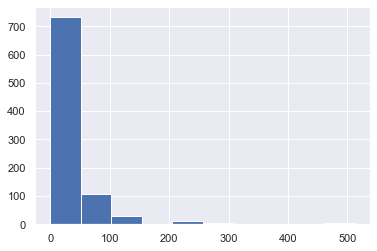

In [19]:
# before removing outliers for Fare.
train_X.Fare.hist()

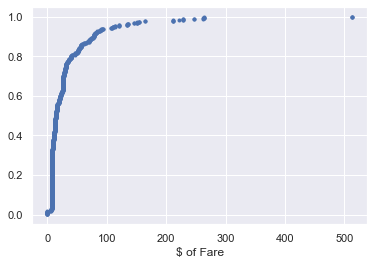

In [20]:
# draw ECDF for Fare before removing outliers.
sns.set()
x, y = ecdf(train_X['Fare'])
plt.xlabel('$ of Fare')
plt.plot(x,y, marker='.', linestyle='none')

In [21]:
# clip with Fare
train_X['Fare'] = train_X['Fare'].clip(upper=fare_max_2) # view those >= fare_max_2 as fare_max_2

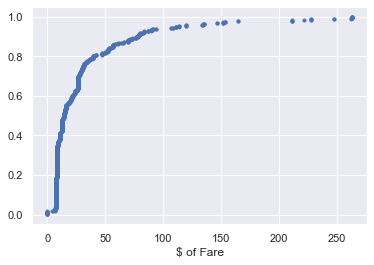

In [22]:
# draw ECDF for Fare
sns.set()
x, y = ecdf(train_X['Fare'])
plt.xlabel('$ of Fare')
plt.plot(x,y, marker='.', linestyle='none')

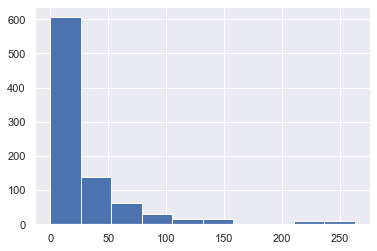

In [23]:
# after removing outliers for Fare.
train_X.Fare.hist()

In [59]:
t = '2' + '3' + str(2)
int(t)

232

In [64]:
train_X

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500
...,...,...,...,...,...
886,2,27.0,0,0,13.0000
887,1,19.0,0,0,30.0000
888,3,NaN,1,2,23.4500
889,1,26.0,0,0,30.0000


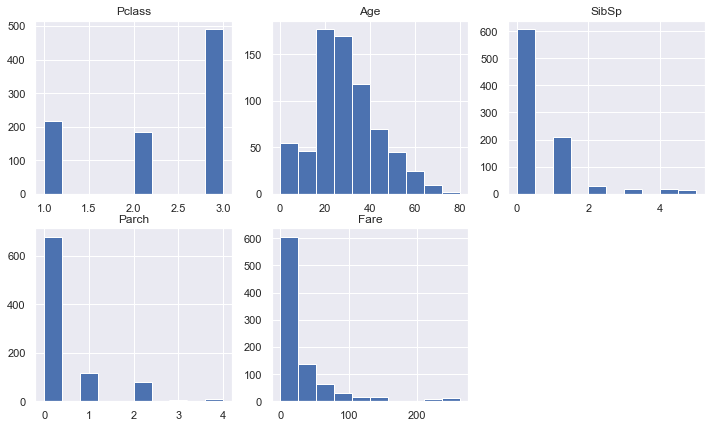

In [63]:
plt.figure(figsize=(12,7))

for i in range(len(train_X.columns)):
    t = '2' + '3' + str(i+1)
    t = int(t)
    plt.subplot(t)
    train_X[train_X.columns[i]].hist()
    plt.title(train_X.columns[i])

In [24]:
def set_missing_ages(df):

    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[['Age','Pclass', 'SibSp', 'Parch', 'Fare']]

    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].values
    unknown_age = age_df[age_df.Age.isnull()].values

    # y即目标年龄
    y = known_age[:, 0]

    # X即特征属性值
    X = known_age[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)

    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age[:, 1:])
    #print predictedAges
    # 用得到的预测结果填补原缺失数据
    df.loc[(df.Age.isnull()), 'Age' ] = predictedAges 

    return df

In [25]:
train_X.isnull().sum()

Pclass      0
Age       177
SibSp       0
Parch       0
Fare        0
dtype: int64

# 作業2
* 使用不同的標準化方式 ( 原值 / 最小最大化 / 標準化 )，搭配羅吉斯迴歸模型，何者效果最好?

In [26]:
# 空值補 -1, 做羅吉斯迴歸
train_X_1 = train_X.fillna(value=-1)

# Use mean
train_X_2 = train_X.fillna(value=train_X['Age'].mean())

# Use median
train_X_3 = train_X.fillna(value=train_X['Age'].median())

# find the 眾數
value_most = mode(train_X['Age'])[0][0]
train_X_4 = train_X.fillna(value=value_most)

# random forest
#train_X_5 = set_missing_ages(train_X)

In [27]:
print(train_X.isnull().sum())

test = [train_X_1, train_X_2, train_X_3, train_X_4]
test_2 = test.copy()

Pclass      0
Age       177
SibSp       0
Parch       0
Fare        0
dtype: int64


In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [34]:
# test for scores without transformation

for i in range(len(test)):
    estimator = LogisticRegression()
    print(cross_val_score(estimator, test[i], train_Y, cv=5).mean())

0.7049149457033457
0.7004205636808738
0.6970560542338836
0.6936852677170297


In [29]:
# transform the data with minmax, Logistic

for i in range(len(test)):
    estimator = LogisticRegression()
    test[i] = MinMaxScaler().fit_transform(test[i])
    print(cross_val_score(estimator, test[i], train_Y, cv=5).mean())

0.7049149457033457
0.7004205636808738
0.6970560542338836
0.6936852677170297


In [35]:
# transform the data with minmax, KNeighborsClassifier

for i in range(len(test)):
    estimator = KNeighborsClassifier()
    test[i] = MinMaxScaler().fit_transform(test[i])
    print(cross_val_score(estimator, test[i], train_Y, cv=5).mean())

0.7003766241918272
0.6880421819094847
0.6902830958508568
0.6981357102504551


In [45]:
# transform the data with minmax, DecisionTreeClassifier

for i in range(len(test)):
    estimator = DecisionTreeClassifier(random_state=0)
    test[i] = MinMaxScaler().fit_transform(test[i])
    print(cross_val_score(estimator, test[i], train_Y, cv=5).mean())

0.6700458226100057
0.6419747661791476
0.648672399723809
0.6452953361370912
